# Finetuning DziriBERT for Dialect Detection

DziriBERT is a BERT language model trained and tested on 1.1 Million Algerian tweets, it was introduced in [this paper](https://arxiv.org/abs/2109.12346) and is available on the Hugging Face Model Hub in [this link](https://huggingface.co/alger-ia/dziribert), which means it is fairly easy to use and finetune the model. In this blog post i'll show how to finetune DziriBERT for dialect detection. The dataset i will be using is of one the [MSDA open datasets](https://msda.um6p.ma/msda_datasets), it contains tweets labelled by country-level dialect. All of the five dialects in this dataset have their roots in Arabic, which means that there are lots of similarities between them especially the ones that are geographically close (e.g. Moroccan and Algerian dialects).

We start by installing the transformers library and importing what we need for the implementation.

In [ ]:
!pip install -q transformers

     |████████████████████████████████| 2.9 MB 5.1 MB/s 
     |████████████████████████████████| 895 kB 32.6 MB/s 
     |████████████████████████████████| 596 kB 56.7 MB/s 
     |████████████████████████████████| 3.3 MB 46.7 MB/s 
     |████████████████████████████████| 56 kB 4.0 MB/s 


In [ ]:
import pandas as pd 

from sklearn.model_selection import train_test_split

from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import AutoModel, BertTokenizerFast, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [ ]:
# mount colab
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = Path('/content/drive/MyDrive/ml/projects/msda_dataset/dialect')

### MSDA Dialect Detection Dataset

The dataset is available as a csv file and can be found in [this link](https://msda.um6p.ma/msda_datasets). I want to mention that you can apply the finetuning process in this post on the other MSDA text classification datasets, you just might need to take into consideration that they are imbalanced.



In [ ]:
df = pd.read_csv(path/'dialect.csv')
df.tail()

,Twits,dialect
53398,هاي باهي وليت تفهم في اللبسة متاع الرجال 🤔🤔,Tunisian
53399,ريي يصبر امها,Tunisian
53400,اللهم امين يارب العالمين ربي يصبر أهلهم,Tunisian
53401,اللهم امين يارب العالمين مخيبها عواشر لا حول و...,Tunisian
53402,لا حول ولا قوة الا بالله جريمة بشعة في wangen ...,Tunisian


This is the number of training examples for each class in our dataset.

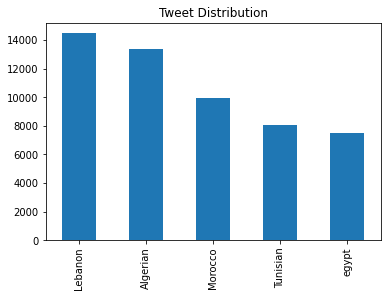

In [ ]:
df.dialect.value_counts().plot.bar(x=df.dialect.unique(), title='Tweet Distribution')

We encode the labels by mapping each dialect to an index.

In [ ]:
dialects = df['dialect'].unique()

lbl2idx = {d: i for i, d in enumerate(dialects)}

df['dialect'] = df['dialect'].map(lbl2idx)

In [ ]:
df['dialect'].unique()

array([0, 1, 2, 3, 4])

We split the dataset randomly, 70% will be used for training, and 30% for validation and testing of the model.

In [ ]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Twits'], df['dialect'], random_state=42, 
                                                                    test_size=0.3)

val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, random_state=42, 
                                                                test_size=0.5)

len(train_texts), len(val_texts), len(test_texts)

(37382, 8010, 8011)

### DziriBERT tokenizer

We need to specify the name of the model on the Hugging Face Hub, we download first the pretrained DziriBERT tokenizer, which will take care of tokenizing and numeracalizing our sequences as DziriBERT model expects them.

In [ ]:
BERT_MODEL_NAME = 'alger-ia/dziribert'

tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/176 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/620 [00:00<?, ?B/s]

Tokenization is the process of splitting text into tokens, which can be words, characters or subwords. BERT uses an algorithm called [WordPiece](https://paperswithcode.com/method/wordpiece) for tokenization, it's a subword tokenization algorithm that was pretrained to know which groups of characters to keep together, the most frequent word pieces are the one kept in the vocabulary of the model. We can see bellow that some words are split into pieces while some others are kept as they are. Some tokens are preceded by `"##"`, this means that that is a completion of a word and should be attached to the previous token when decoding. 

In [ ]:
tokens = tokenizer.tokenize(train_texts[0])
print(tokens)

['الدكتورة', 'نجوى', 'قامة', 'في', 'القصف', 'الصار', '##وخ', '##ي', 'لك', 'ان', 'ترى', 'منشورات', '##ها', 'وتدخل', '##اتها']


This is the original sequence.

In [ ]:
train_texts[0]

'الدكتورة نجوى قامة في القصف الصاروخي لك ان ترى منشوراتها وتدخلاتها'

Before feeding our inputs to the model, we need to convert them to numbers. What we see bellow is the index of each token in the vocabulary of the pretrained DziriBERT WordPiece tokenizer. When finetuning the model, these indices will be used to retrieve the embedding vector of each token that was learned during pretraining.

In [ ]:
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

[45796, 40053, 48544, 1821, 20759, 41048, 4769, 1016, 2374, 1828, 5601, 19452, 1814, 30404, 3985]


 A vocabulary is a dictionary that maps the tokens learned by WordPiece to indices, tokens that are not in the vocabulary are usually replaced with a special token (e.g. `[UNK]`).

In [ ]:
tokenizer.vocab[tokens[0]]

45796

`encode_plus` is a chain of multiple steps to prepare the inputs of our model, this includes the ones we discussed before (`tokenize` and `encode_tokens_to_ids`), along with others like padding. We can see it has two outputs, `input_ids` which is similar to the output of `encode_tokens_to_ids`, and an another output which is `attention_mask`, this is used to indicate to the model the position of the padding tokens, this is done so that the attention layers can ignore them when computing token representations. 1 indicates an original token and 0 is for the padding token, which we can't see in the output because padding is not needed, it is usually useful when batching sequences together and we will see that bellow, we will also see where that 2 and 3 in the `input_ids` came from.

In [ ]:
tokenizer.encode_plus(train_texts[0], return_token_type_ids=False)

{'input_ids': [2, 45796, 40053, 48544, 1821, 20759, 41048, 4769, 1016, 2374, 1828, 5601, 19452, 1814, 30404, 3985, 3], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

We usually want our model to take a batch of sequences, to do that, sequences must have the same length, one way we can do this is to grab the longest sequence in a batch and pad all the other sequences to have the same length. 

`batch_encode_plus` encodes a batch of sequences, we can see that the second sentence is padded with zeros to the length of the longest sequence in the batch, which is the first sentence, and its `attention_mask` also contains zeros indicating which tokens are padding.

In [ ]:
tokenizer.batch_encode_plus(train_texts[:2].to_list(), padding=True, return_token_type_ids=False)

{'input_ids': [[2, 7654, 5405, 4434, 5699, 20924, 2039, 20735, 2738, 8576, 7893, 1846, 22439, 5793, 24691, 36283, 43820, 6066, 2464, 3], [2, 4473, 2000, 5023, 1843, 21960, 1823, 1821, 5301, 4481, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

Decoding is reversing the operations that were applied to the text, but we see that there are two new tokens (`[CLS]` and `[SEP]`) in our sequence, these are called special tokens and their indices in the vocabulary are 2 and 3, they are added by the tokenizer and to explain why, i will talk a bit about the training objectives of BERT.

BERT language models are usually trained with two training objectives, Masked Language Modelling (MLM) and Next Sentence Prediction (NSP). 

**Masked Language Modelling (MLM)** is used in most if not all tranformer based models, at first, we mask a percentage of the input tokens, 15% in the original BERT but 25% in the case of DziriBERT as they state in [their paper](https://arxiv.org/abs/2109.12346), the reason as they mention is that DziriBERT is trained on tweets and they have a short length. The model is asked to predict the masked tokens based on their context (non-masked tokens), this way the model will learn language representations that can be useful when finetuning on downstream tasks.

**Next Sentence Prediction** is a classification task where BERT takes a pair of sentences, and tries to predict whether the second sentence is the next sentence or not. This was shown to increase the performance of BERT especially in tasks that involve pairs of sentences (e.g. Question Answering (QA), Natural Language Inference (NLI), ...) as was declared in the [BERT paper](https://arxiv.org/abs/1810.04805). The pairs of sentences are separated by `[SEP]` token, and you can see bellow how the input of BERT should look like when doing NSP. The `[CLS]` token is used at the beginning of each input, as BERT outputs a vector representation for each token in the sequence, it will use only the representation of the `[CLS]` token to do Next Sentence Prediction. This way, the `[CLS]` token is thought to encode information about the whole input sequence, and that is why it is usually used in text classification tasks like ours.

> Note: DziriBERT is trained without NSP objective, and they cite in [the paper](https://arxiv.org/abs/2109.12346) that it was shown that it does not improve the results of downstream tasks.

In [ ]:
out = tokenizer.encode_plus(train_texts[0], return_token_type_ids=False)
tokenizer.decode(out['input_ids'])

'[CLS] الدكتورة نجوى قامة في القصف الصاروخي لك ان ترى منشوراتها وتدخلاتها [SEP]'

This is what normally the input of BERT would look like during pretraining with an NSP objective.

In [ ]:
tok_out = tokenizer(train_texts[0], train_texts[2])
tokenizer.decode(tok_out['input_ids'])

'[CLS] الدكتورة نجوى قامة في القصف الصاروخي لك ان ترى منشوراتها وتدخلاتها [SEP] 😂😂😂😂😂 شكون يعرفها🤔 [SEP]'

### Finetuning the model

We take a look at the length of sequences in our training set.

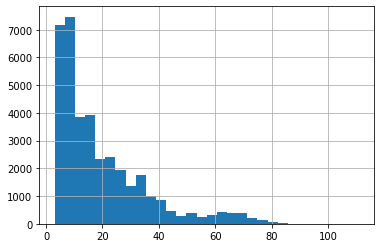

In [ ]:
seq_len = [len(tokenizer.encode(i)) for i in train_texts]

pd.Series(seq_len).hist(bins = 30)

The maximum sequence length that BERT can take is 512, but that would be too much for our case, since most sequences contain less than 40 tokens. We specify that for our tokenizer in `max_length` and set `truncation` to `true`, what this means is that any sequence longer than 40 will be truncated to `max_seq_len`. With that, we will lose some informations but it will reduce the training time, and that matters a lot when training on free colab 😄.

In [ ]:
max_seq_len = 40

train_encodings = tokenizer(train_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
val_encodings = tokenizer(val_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
test_encodings = tokenizer(test_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)

We create a Pytorch dataset class, which has two essential methods, `__len__` that should return the number of samples in the dataset, and `__get_item__` which will return the item (encoding and label) at index `idx`.

In [ ]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.to_list()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

To evaluate our model while training, we need to pass a function that takes the model's predictions, and compute the metrics that we care about. In our case we will compute the accuracy, f1 score, precision and recall because our dataset is imbalanced, and also to compare with the baselines in [MSDA paper](https://arxiv.org/abs/2102.11000).

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

Now is time to load the pretrained DziriBERT model from Hugging Face Hub. What `AutoModelForSequenceClassification` does is to remove the pretraining head of the model, and replace it with a classification head that will be initialized randomly. This classification head is just a linear layer that will take  something called `pooler_output` as input and output 5 numbers (as specified in `num_labels`) for each sequence, these are called logits and they are passed through a softmax function to get probabilities when computing the loss or to when computing metrics.

`pooler_output` is one of the outputs of a BERT model, it is the representation of the `[CLS]` token after it was passed through a linear layer followed by a tanh activation function.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=5)

Downloading:   0%|          | 0.00/475M [00:00<?, ?B/s]

Some weights of the model checkpoint at alger-ia/dziribert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are

Taking a look at logits.

In [ ]:
out = tokenizer.encode_plus(train_texts[0], return_token_type_ids=False, return_tensors='pt')

model.eval()
with torch.no_grad():
  print(model(**out)['logits'])

tensor([[ 0.0181, -0.0198, -0.2928,  0.1794,  0.1907]])


The `Trainer` is what takes care of training our models, it takes arguments through the `TrainingArguments` class, and takes our model, datasets and the method to compute metrics and output them on a nice table during training. calling `train` will start finetuning our classification model, and what we need now is to find something to do instead of looking at the progress bar 😁. 

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    evaluation_strategy='epoch',     # evaluate at the end of each epoch
    logging_strategy='epoch'        # log at the end of each epoch
    )

trainer = Trainer(
    model=model,                         # the instantiated Transformers model 
    args=training_args,                  # training arguments
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics      # method we defined before to compute our metrics
    )

trainer.train()

***** Running training *****
  Num examples = 37382
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5845


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.650000,0.494892,0.826592,0.826592,0.826592,0.826592
2,0.300600,0.468697,0.841199,0.841199,0.841199,0.841199
3,0.142800,0.587720,0.846941,0.846941,0.846941,0.846941
4,0.073500,0.751222,0.853308,0.853308,0.853308,0.853308
5,0.041000,0.836090,0.850312,0.850312,0.850312,0.850312


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8010
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8010
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in 

TrainOutput(global_step=5845, training_loss=0.24160565000196316, metrics={'train_runtime': 3288.5532, 'train_samples_per_second': 56.837, 'train_steps_per_second': 1.777, 'total_flos': 3842141563120800.0, 'train_loss': 0.24160565000196316, 'epoch': 5.0})

`predict` which we pass our test dataset, returns a prediction (logits) for each sample in the dataset, and also computes the metrics that we already passed to the `Trainer`.

In [ ]:
trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 8011
  Batch size = 64


PredictionOutput(predictions=array([[-2.8933556 ,  7.270326  , -1.6885829 , -1.338966  , -2.3586602 ],
       [-1.2138728 , -1.8854287 , -2.3426878 ,  7.971615  , -2.857426  ],
       [-1.9059055 , -1.641494  , -3.739841  ,  0.8998544 ,  6.444405  ],
       ...,
       [-1.78565   ,  6.1445756 , -1.9356711 ,  0.23239179, -3.9032187 ],
       [-0.16582216, -1.4176931 ,  2.6004167 ,  0.93503976, -1.9505943 ],
       [ 8.251636  , -2.1360373 , -2.0708601 , -1.7121732 , -1.773536  ]],
      dtype=float32), label_ids=array([1, 3, 4, ..., 3, 3, 0]), metrics={'test_loss': 0.8449447154998779, 'test_accuracy': 0.8483335413806017, 'test_f1': 0.8483335413806017, 'test_precision': 0.8483335413806017, 'test_recall': 0.8483335413806017, 'test_runtime': 38.7147, 'test_samples_per_second': 206.924, 'test_steps_per_second': 3.255})

---
We get **0.84** across all metrics by finetuning a model that was pretrained on one dialect. To see where we are, we take a look at the baseline results in the [MSDA paper](https://arxiv.org/abs/2102.11000).

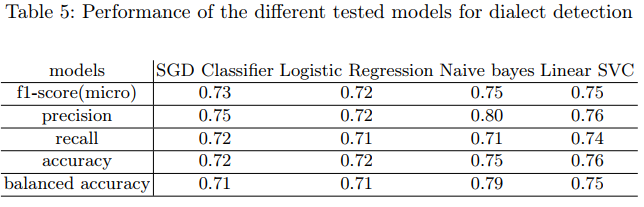

In this [Github repository](https://github.com/issam9/finetuning-bert-models-for-arabic-dialect-detection), i compared DziriBERT to other arabic bert models ([Arabert](https://github.com/aub-mind/arabert) and [Arabic-Bert](https://github.com/alisafaya/Arabic-BERT)) for this task, and it was able to outperform both of them even though they are pretrained on a lot more data. What is surprising is that the version of Arabert i used is pretrained on a dataset that includes 60M of multi-dialect tweets.